User Profile Convergence Analysis

1. Collect logs

In [145]:
from glob import glob
from os import path

training_logs = dict()
profile_logs = dict()

training_logs["original_arch"] = sorted(glob(
    path.join("original_arch", "*_*_loss")))
profile_logs["original_arch"] = sorted(glob(
    path.join("original_arch", "user_profile_*")))

training_logs["new_arch"] = sorted(glob(
    path.join("new_arch", "*_*_loss")))
profile_logs["new_arch"] = sorted(glob(
    path.join("new_arch", "user_profile_*")))

training_logs


{'original_arch': ['original_arch/personalized_model_0_loss',
  'original_arch/personalized_model_100_loss',
  'original_arch/personalized_model_101_loss',
  'original_arch/personalized_model_102_loss',
  'original_arch/personalized_model_103_loss',
  'original_arch/personalized_model_104_loss',
  'original_arch/personalized_model_105_loss',
  'original_arch/personalized_model_106_loss',
  'original_arch/personalized_model_107_loss',
  'original_arch/personalized_model_108_loss',
  'original_arch/personalized_model_109_loss',
  'original_arch/personalized_model_10_loss',
  'original_arch/personalized_model_110_loss',
  'original_arch/personalized_model_111_loss',
  'original_arch/personalized_model_112_loss',
  'original_arch/personalized_model_113_loss',
  'original_arch/personalized_model_114_loss',
  'original_arch/personalized_model_115_loss',
  'original_arch/personalized_model_116_loss',
  'original_arch/personalized_model_117_loss',
  'original_arch/personalized_model_118_loss',

2. Parse logs

In [146]:
import numpy as np
import pandas as pd
import re
from typing import Dict
from typing import List

def ParseTrainingLogs(training_logs: Dict[str, List[str]]) -> pd.DataFrame:
    arch_col = list()
    epoch_col = list()
    losses_col = list()

    for arch, files in training_logs.items():
        for file in files:
            epoch = int(re.search("[0-9]+", file)[0])
            losses = pd.read_csv(file).iloc[:, 1].to_numpy().copy()

            arch_col.append(arch)
            epoch_col.append(epoch)
            losses_col.append(losses)
    
    df = pd.DataFrame(data={
        "arch": arch_col,
        "epoch": epoch_col,
        "losses": losses_col
    })

    df.sort_values(by=["arch", "epoch"], inplace=True)

    return df


def ParseProfileLogs(profile_logs: Dict[str, List[str]]) -> pd.DataFrame:
    arch_col = list()
    epoch_col = list()
    profile_col = list()

    for arch, files in profile_logs.items():
        for file in files:
            epoch = int(re.search("[0-9]+", file)[0])
            profile = np.loadtxt(fname=file)

            arch_col.append(arch)
            epoch_col.append(epoch)
            profile_col.append(profile)

    df = pd.DataFrame(data={
        "arch": arch_col,
        "epoch": epoch_col,
        "profile": profile_col
    })

    df.sort_values(by=["arch", "epoch"], inplace=True)

    return df


In [147]:
training_logs_df = ParseTrainingLogs(training_logs=training_logs)

training_logs_df.head(300)


,arch,epoch,losses
152,new_arch,0,"[9.67924690246582, 8.771215438842773, 8.607007..."
170,new_arch,1,"[6.432865619659424, 6.494903564453125, 6.61101..."
181,new_arch,2,"[6.125980377197266, 6.0667009353637695, 6.0398..."
192,new_arch,3,"[5.771051406860352, 6.064438819885254, 5.60883..."
203,new_arch,4,"[5.812052249908447, 5.725443363189697, 5.81411..."
...,...,...,...
57,original_arch,155,"[4.938009738922119, 5.19385290145874, 4.706366..."
58,original_arch,157,"[5.13249397277832, 4.90904712677002, 5.1804728..."
59,original_arch,158,"[4.738616466522217, 5.187854766845703, 4.95216..."
61,original_arch,160,"[5.156596183776856, 4.877013683319092, 5.08823..."


In [148]:
profile_logs_df = ParseProfileLogs(profile_logs=profile_logs)

profile_logs_df.head(300)


,arch,epoch,profile
162,new_arch,0,"[[-0.453527569770813, -0.3076384961605072, -1...."
163,new_arch,1,"[[-0.4464406967163086, -0.3470284640789032, -1..."
181,new_arch,2,"[[-0.4714100658893585, -0.3542369306087494, -1..."
192,new_arch,3,"[[-0.4436592757701874, -0.32018429040908813, -..."
203,new_arch,4,"[[-0.41824790835380554, -0.34481683373451233, ..."
...,...,...,...
65,original_arch,157,"[[1.341121792793274, -1.1477199792861938, 1.35..."
66,original_arch,158,"[[1.4072128534317017, -1.134041666984558, 1.36..."
67,original_arch,159,"[[1.3551554679870605, -1.1128673553466797, 1.3..."
69,original_arch,160,"[[1.362733244895935, -1.08426833152771, 1.3819..."


3. Training Curve Comparison

In [149]:
from scipy.stats import t

CONFIDENCE_LEVEL = 0.95


def ComputeEpochLoss(df: pd.DataFrame) -> pd.DataFrame:
    arch_col = list()
    epoch_col = list()
    avg_loss_col = list()
    upper_loss_col = list()
    lower_loss_col = list()

    for k, v in df.groupby(by=["arch", "epoch"]):
        if v["losses"].iloc[0].shape[0] == 0:
            continue
        
        samples = v["losses"].iloc[0]
        sample_count = samples.shape[0]

        avg_loss = np.mean(samples)
        std_loss = np.std(samples)
        ci_loss = t.interval(
            CONFIDENCE_LEVEL, sample_count - 1,
            loc=avg_loss, 
            scale=std_loss / np.sqrt(sample_count))

        arch_col.append(k[0])
        epoch_col.append(k[1])
        avg_loss_col.append(avg_loss)
        lower_loss_col.append(ci_loss[0])
        upper_loss_col.append(ci_loss[1])
    
    return pd.DataFrame(data={
        "arch": arch_col,
        "epoch": epoch_col,
        "loss": avg_loss_col,
        "lower_loss": lower_loss_col,
        "upper_loss": upper_loss_col,
    })

loss_df = ComputeEpochLoss(df=training_logs_df)

loss_df.head(5)
loss_df.head(-5)

,arch,epoch,loss,lower_loss,upper_loss
0,new_arch,0,7.077386,6.963719,7.191054
1,new_arch,1,6.303301,6.261307,6.345294
2,new_arch,2,6.031899,6.001933,6.061866
3,new_arch,3,5.858117,5.821150,5.895084
4,new_arch,4,5.757225,5.721685,5.792764
...,...,...,...,...,...
248,original_arch,148,4.999533,4.962383,5.036684
249,original_arch,149,5.000243,4.964248,5.036238
250,original_arch,150,4.986452,4.951902,5.021002
251,original_arch,151,4.994807,4.961437,5.028176


     epoch      loss  lower_loss  upper_loss
107      0  7.185875    7.079440    7.292310
108      1  6.515411    6.474474    6.556348
109      2  6.231971    6.198233    6.265708
110      3  6.064023    6.031131    6.096915
111      4  5.946689    5.912230    5.981148
..     ...       ...         ...         ...
253    154  4.990025    4.951976    5.028073
254    155  4.976276    4.945419    5.007134
255    157  4.997970    4.963683    5.032256
256    158  4.989570    4.955220    5.023920
257    160  4.987028    4.955782    5.018273

[151 rows x 4 columns]
     epoch      loss  lower_loss  upper_loss
0        0  7.077386    6.963719    7.191054
1        1  6.303301    6.261307    6.345294
2        2  6.031899    6.001933    6.061866
3        3  5.858117    5.821150    5.895084
4        4  5.757225    5.721685    5.792764
..     ...       ...         ...         ...
102    102  4.636468    4.596567    4.676369
103    103  4.678717    4.635797    4.721638
104    104  4.648650    4.60863

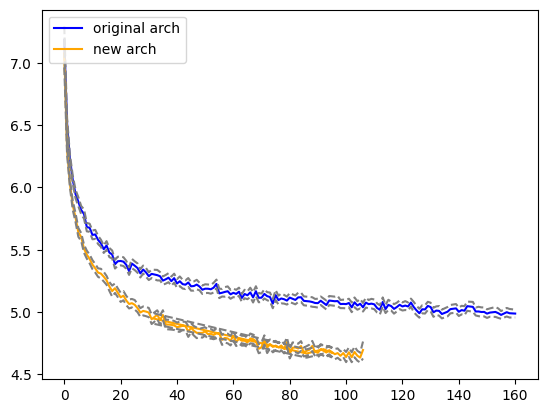

In [150]:
import matplotlib.pyplot as plt

loss_ori = loss_df[loss_df.arch == "original_arch"][[
    "epoch", "loss", "lower_loss", "upper_loss"]]
loss_new = loss_df[loss_df.arch == "new_arch"][[
    "epoch", "loss", "lower_loss", "upper_loss"]]

print(loss_ori.head(300))
print(loss_new.head(300))

loss_all = pd.merge(left=loss_ori, right=loss_new, on="epoch", how="outer")

plt.plot(loss_all.epoch, loss_all.loss_x, color="blue", label="original arch")
plt.plot(loss_all.epoch, loss_all.lower_loss_x, "--", color="grey")
plt.plot(loss_all.epoch, loss_all.upper_loss_x, "--", color="grey")

plt.plot(loss_all.epoch, loss_all.loss_y, color="orange", label="new arch")
plt.plot(loss_all.epoch, loss_all.lower_loss_y, "--", color="grey")
plt.plot(loss_all.epoch, loss_all.upper_loss_y, "--", color="grey")

plt.legend(loc="upper left")


4. Profile Comparison

In [151]:
def FrameOfReference(profile: np.ndarray):
    return np.mean(profile, axis=0)

def L2(a: np.ndarray, b: np.ndarray) -> float:
    return np.sum((a - b)*(a - b))

def Movement(profile: np.ndarray, origin: np.ndarray):
    diff = profile - origin
    l2s = np.sqrt(np.sum(diff*diff, axis=1))
    return np.mean(l2s)

def ComputeDisplacement(profile_logs_df: pd.DataFrame) -> pd.DataFrame:
    arch_col = list()
    epoch_col = list()
    movement_col = list()
    shift_col = list()

    archs = profile_logs_df.arch.unique()

    for arch in archs:
        profiles = profile_logs_df[profile_logs_df.arch == arch][["epoch", "profile"]]
        origin = profiles[profiles.epoch == 0].profile.to_numpy()[0]
        origin_frame = FrameOfReference(profile=origin)

        for _, row in profiles.iterrows():
            epoch = row.epoch

            current_frame = FrameOfReference(profile=row["profile"])
            shift = L2(current_frame, origin_frame)
            shift_vector = current_frame - origin_frame

            corrected_profile = row.profile - shift_vector
            movement = Movement(profile=corrected_profile, origin=origin)
            
            arch_col.append(arch)
            epoch_col.append(epoch)
            movement_col.append(movement)
            shift_col.append(shift)

    return pd.DataFrame(data={
        "arch": arch_col,
        "epoch": epoch_col,
        "movement": movement_col,
        "shift": shift_col,
    })


movement_df = ComputeDisplacement(profile_logs_df=profile_logs_df)
movement_df.head(300)


,arch,epoch,movement,shift
0,new_arch,0,0.000000,0.000000
1,new_arch,1,0.078244,0.000007
2,new_arch,2,0.126568,0.000012
3,new_arch,3,0.175270,0.000028
4,new_arch,4,0.224443,0.000045
...,...,...,...,...
264,original_arch,157,2.076076,0.063679
265,original_arch,158,2.079729,0.064403
266,original_arch,159,2.082416,0.064898
267,original_arch,160,2.084261,0.065186


     epoch  movement     shift
107      0  0.000000  0.000000
108      1  0.068356  0.000007
109      2  0.123521  0.000045
110      3  0.183045  0.000137
111      4  0.253166  0.000292
..     ...       ...       ...
264    157  2.076076  0.063679
265    158  2.079729  0.064403
266    159  2.082416  0.064898
267    160  2.084261  0.065186
268    161  2.087317  0.066294

[162 rows x 3 columns]
     epoch  movement     shift
0        0  0.000000  0.000000
1        1  0.078244  0.000007
2        2  0.126568  0.000012
3        3  0.175270  0.000028
4        4  0.224443  0.000045
..     ...       ...       ...
102    102  2.064129  0.010086
103    103  2.068892  0.010165
104    104  2.073313  0.010319
105    105  2.077954  0.010548
106    106  2.082599  0.010597

[107 rows x 3 columns]


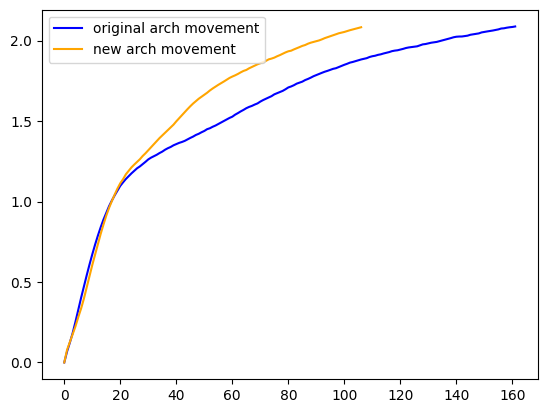

In [152]:
mov_ori = movement_df[movement_df.arch == "original_arch"][[
    "epoch", "movement", "shift"]]
mov_new = movement_df[movement_df.arch == "new_arch"][[
    "epoch", "movement", "shift"]]

print(mov_ori.head(300))
print(mov_new.head(300))

mov_all = pd.merge(left=mov_ori, right=mov_new, on="epoch", how="outer")

plt.plot(mov_all.epoch, mov_all.movement_x, color="blue", label="original arch movement")
plt.plot(mov_all.epoch, mov_all.movement_y, color="orange", label="new arch movement")

plt.legend(loc="upper left")


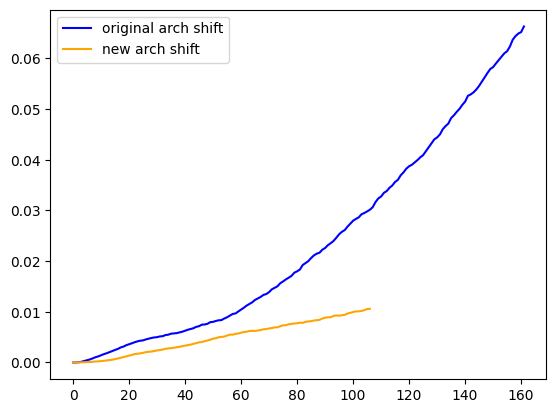

In [153]:
plt.plot(mov_all.epoch, mov_all.shift_x, color="blue", label="original arch shift")
plt.plot(mov_all.epoch, mov_all.shift_y, color="orange", label="new arch shift")

plt.legend(loc="upper left")


5. Profile Structure

In [154]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# ori_arch_profile = profile_logs_df[
#     (profile_logs_df.arch == "original_arch") & (profile_logs_df.epoch == 161)].profile.iloc[0]

# # Perform t-SNE embedding on the dataset
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(ori_arch_profile)

# # Create a scatter plot of the t-SNE embedding
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1])


In [155]:
# new_arch_profile = profile_logs_df[(profile_logs_df.arch == "new_arch") & (
#     profile_logs_df.epoch == 104)].profile.iloc[0]

# # Perform t-SNE embedding on the dataset
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(new_arch_profile)

# # Create a scatter plot of the t-SNE embedding
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1])


In [156]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# fig, ax = plt.subplots()
# sc = None

# def update(frame):
#     profile = profile_logs_df[(profile_logs_df.arch == "new_arch") & (
#         profile_logs_df.epoch == frame)].profile.iloc[0]

#     # Perform t-SNE embedding on the dataset
#     # tsne = TSNE(n_components=2, random_state=42)
#     # X_tsne = tsne.fit_transform(profile)

#     global sc
#     if sc is None:
#         sc = ax.scatter(profile[:, 1], profile[:, 3])
#     else:
#         sc.set_offsets(np.c_[profile[:, 1], profile[:, 3]])

#     return sc,


# # Create the animation
# ani = FuncAnimation(fig, update, frames=105, interval=100, blit=True)

# # Save the animation as a GIF
# ani.save('profile-1-2.gif', writer='imagemagick')
